In [1]:
import random
import pandas as pd
import json
import os
from tqdm import tqdm

os.chdir("/Users/abz/Desktop/UNB/Thesis/Code/Thesis-Code/FNDdataset")

from utils.webpage_crawler import WebpageProcessor
from crawl4evidence import should_filter_link
processor = WebpageProcessor()

cache_webpages_dir = "data/webpages"

with open("data/search_results_v2.json", "r") as f:
    search_results = json.load(f)

with open("data/claim_queries_v2.json", "r") as f:
    claim_decompositions = json.load(f)

In [2]:
# Calculate average decompositions per claim
total_claims = len(claim_decompositions)
total_decomp = sum([len(decompositions) for claim, decompositions in  claim_decompositions.items()])/total_claims

print("Total claims: ", total_claims)
print("Average decompositions per claim: ", total_decomp)

Total claims:  2684
Average decompositions per claim:  3.665797317436662


In [2]:
# page = processor.url2lines("https://sv.usembassy.gov/visas/important-visa-information/", method="selenium")
# processor.cleanup()
# from pprint import pprint
# pprint(page)

In [3]:
# processor.cleanup()

In [3]:
# Domain analysis
# Gather all the domains of the retrieved results
# Analyze the domains - 
# 1. Number of articles per domain
# 2. Recency of the articles per domain

from urllib.parse import urlparse
import tldextract

# def get_domain_name(url):
#     if '://' not in url:
#         url = 'http://' + url
#     extracted = tldextract.extract(url)
#     return f"{extracted.domain}.{extracted.suffix}"

def get_domain_name(url):
    if '://' not in url:
        url = 'http://' + url
    
    extracted = tldextract.extract(url)
    # Include subdomain if it exists
    if extracted.subdomain:
        return f"{extracted.subdomain}.{extracted.domain}.{extracted.suffix}"
    return f"{extracted.domain}.{extracted.suffix}"

def extract_domain(url):
    """Extracts the domain from a URL."""
    parsed_uri = urlparse(url)
    domain = parsed_uri.netloc.lower()
    if domain.startswith('www.'):
        domain = domain[4:]
    return domain

domain_articles_map = {}
articles_date_map = {}
domain_date_map = {}
for (claim, queries) in search_results.items():
    for (query, page_results) in queries.items():
        for page_num, results in page_results.items():
            for result_object in results:
                link = result_object["link"]

                if should_filter_link(link):
                    continue

                date = result_object["date"] if "date" in result_object else None
                domain = get_domain_name(link)      

                if domain not in domain_articles_map:
                    domain_articles_map[domain] = set([link])
                else:
                    domain_articles_map[domain].add(link)

                if link in articles_date_map and date is not None:
                    articles_date_map[link] = date
                else:
                    articles_date_map[link] = date
print("Total domains: ", len(domain_articles_map))
print("Total articles: ", len(articles_date_map))

for domain, articles_list in domain_articles_map.items():   
    for link in articles_list:
        date = articles_date_map[link]
        if date is not None:
            if domain not in domain_date_map:
                domain_date_map[domain] = [date]
            else:
                domain_date_map[domain].append(date)


Blacklisted file type:  https://www.bls.gov/news.release/pdf/cpi.pdf
Blacklisted file type:  https://www.cbo.gov/system/files/2024-09/60480-Inflation.pdf
Blacklisted file type:  https://www.bls.gov/news.release/archives/cpi_08102023.pdf
Blacklisted file type:  https://www.acluaz.org/sites/default/files/field_documents/aclu_border_rights.pdf
Blacklisted file type:  https://www.supremecourt.gov/opinions/21pdf/21-147_g31h.pdf
Blacklisted file type:  http://heepyungcho.web.illinois.edu/docs/100Miles.pdf
Blacklisted file type:  https://www.lcv.org/wp-content/uploads/archive/2016/10/rubio-wrong-for-florida.pdf
Blacklisted file type:  https://www.lcv.org/wp-content/uploads/archive/2016/10/rubio-wrong-for-florida.pdf
Blacklisted file type:  https://www.energycapitaled.com/wp-content/uploads/2016/10/Seven-Big-Failed-Environmentalist-Predictions.pdf
Blacklisted file type:  https://www.energycapitaled.com/wp-content/uploads/2016/10/Seven-Big-Failed-Environmentalist-Predictions.pdf
Blacklisted fil

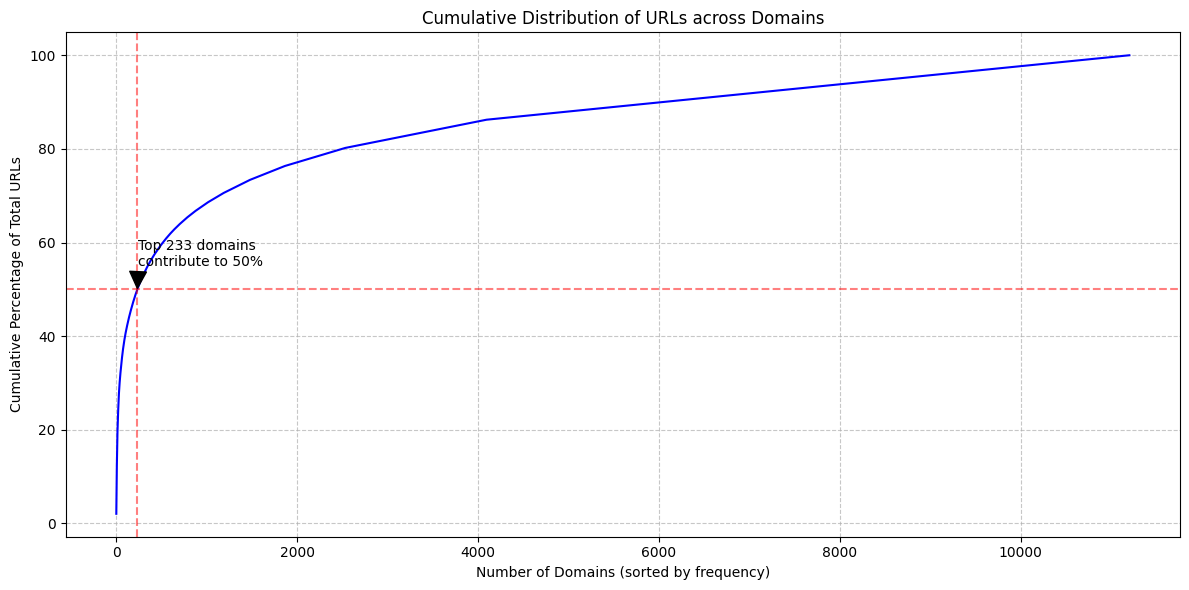

Top 233 domains (2.1%) contribute to 50% of all URLs
Total number of domains: 11201


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate domain frequencies and cumulative percentages
domain_counts = pd.DataFrame.from_dict([{'domain': domain, 'articles_count': len(articles_list)} for domain, articles_list in domain_articles_map.items()])
domain_counts = domain_counts.sort_values('articles_count', ascending=False).reset_index(drop=True)
domain_counts['cumulative_percentage'] = (
    domain_counts['articles_count'].cumsum() / 
    domain_counts['articles_count'].sum() * 100
)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(domain_counts) + 1), domain_counts['cumulative_percentage'], 'b-')
plt.grid(True, linestyle='--', alpha=0.7)

# Add reference lines for 50% threshold
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5)
domains_for_50 = len(domain_counts[domain_counts['cumulative_percentage'] <= 50])
plt.axvline(x=domains_for_50, color='r', linestyle='--', alpha=0.5)

# Formatting
plt.title('Cumulative Distribution of URLs across Domains')
plt.xlabel('Number of Domains (sorted by frequency)')
plt.ylabel('Cumulative Percentage of Total URLs')

# Add annotation for the 50% threshold
plt.annotate(f'Top {domains_for_50} domains\ncontribute to 50%',
            xy=(domains_for_50, 50),
            xytext=(domains_for_50 + 10, 55),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Top {domains_for_50} domains ({domains_for_50/len(domain_counts)*100:.1f}%) contribute to 50% of all URLs")
print(f"Total number of domains: {len(domain_counts)}")

# Save top domains
with open("data/top_domains_50.txt", "w") as f:
    top_domains = domain_counts[domain_counts['cumulative_percentage'] <= 50]
    for _, row in top_domains.iterrows():
        f.write(f"{row['domain']} | {row['articles_count']}\n")

# Save all domain as a list
with open("data/domains.json", "w") as f:
    json.dump(list(domain_articles_map.keys()), f)

In [6]:
domain_counts.head(25)

,domain,articles_count,cumulative_percentage
0,en.wikipedia.org,1060,2.053428
1,www.cnn.com,1051,4.089421
2,pmc.ncbi.nlm.nih.gov,922,5.875516
3,apnews.com,900,7.618992
4,www.reuters.com,861,9.286918
5,www.nytimes.com,793,10.823115
6,www.usatoday.com,773,12.320567
7,www.npr.org,624,13.529378
8,www.cbsnews.com,606,14.703318
9,www.washingtonpost.com,606,15.877259


In [7]:
# Analyze dates and create domain metrics
domain_metrics = {}
reference_date = pd.Timestamp.now()
# reference_date = pd.Timestamp('2024-11-10')

for domain, dates_list in domain_date_map.items():
    try:
        # Convert string dates to datetime
        parsed_dates = []
        for date_str in dates_list:
            try:
                if date_str is not None:    
                    date = pd.to_datetime(date_str, format='%b %d, %Y')
                    parsed_dates.append(date)
            except (ValueError, TypeError):
                continue
        
        if parsed_dates:  # Only create metrics if we have valid parsed dates
            recency_scores = [1 - (reference_date - date).days/365.0 for date in parsed_dates]
            domain_metrics[domain] = {
                'article_count': len(domain_articles_map[domain]),  # Total articles from domain_articles_map
                'articles_with_dates': len(parsed_dates),          # Articles with valid dates
                'earliest': min(parsed_dates),
                'latest': max(parsed_dates),
                'recency_score_avg': sum(recency_scores) / len(recency_scores)
            }
    except Exception as e:
        print(f"Warning: Could not process dates for domain {domain}: {str(e)}")


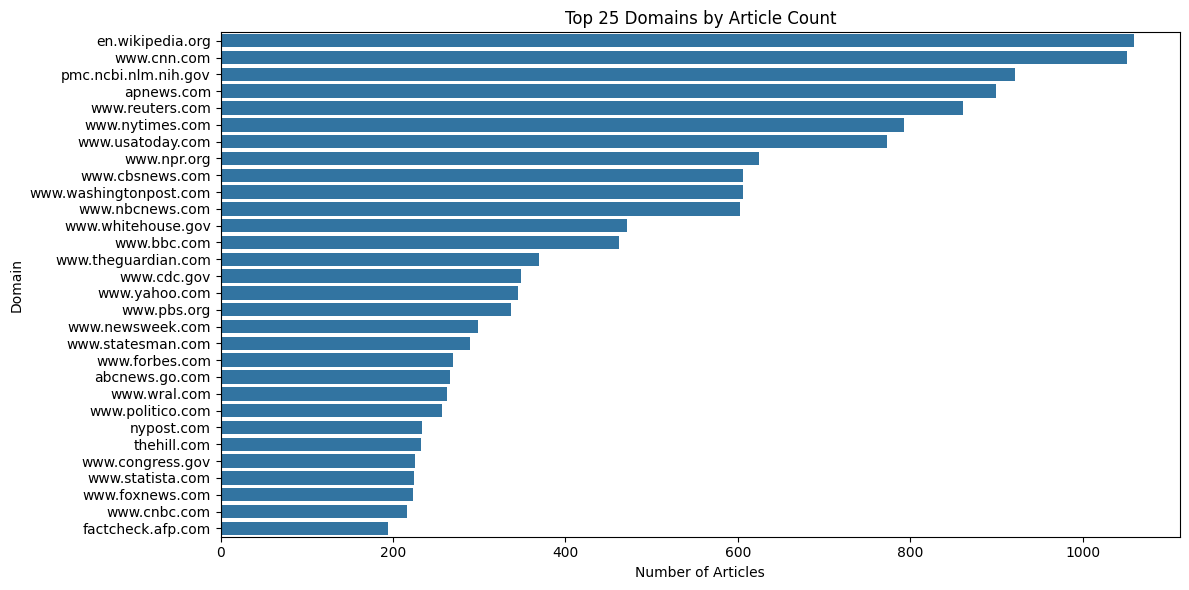

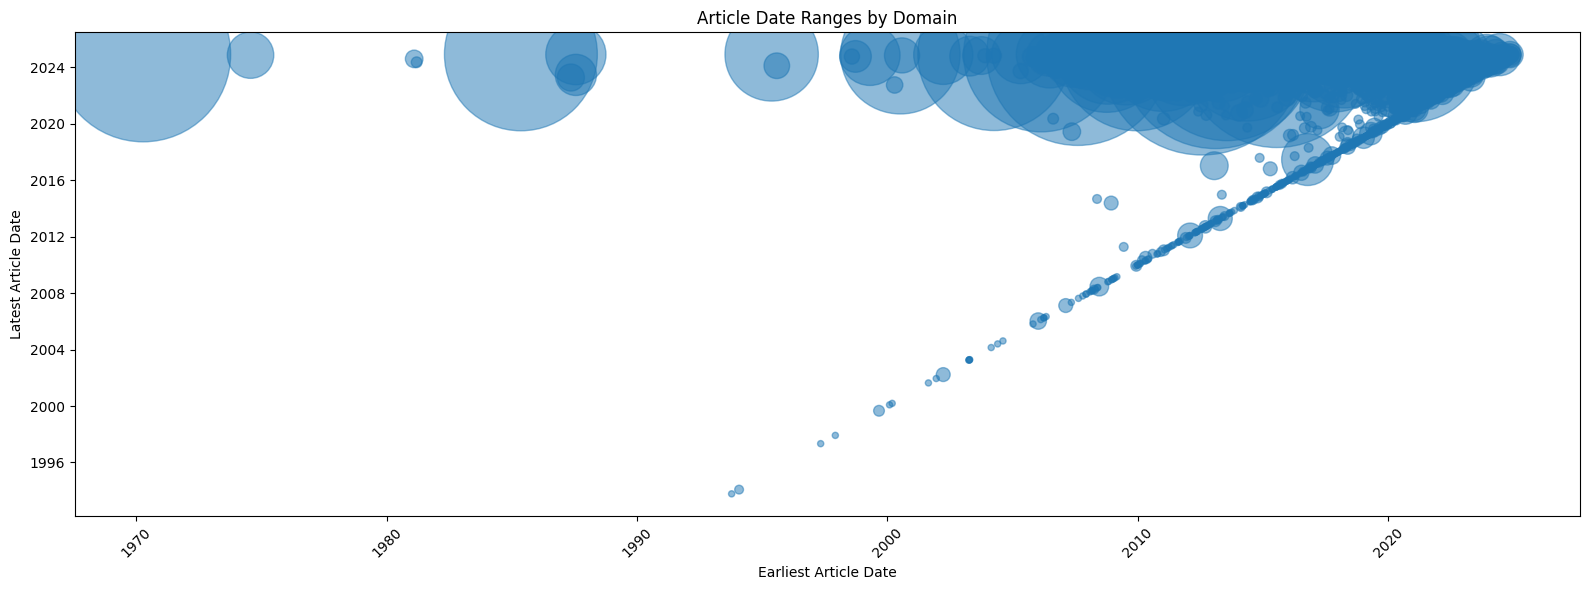

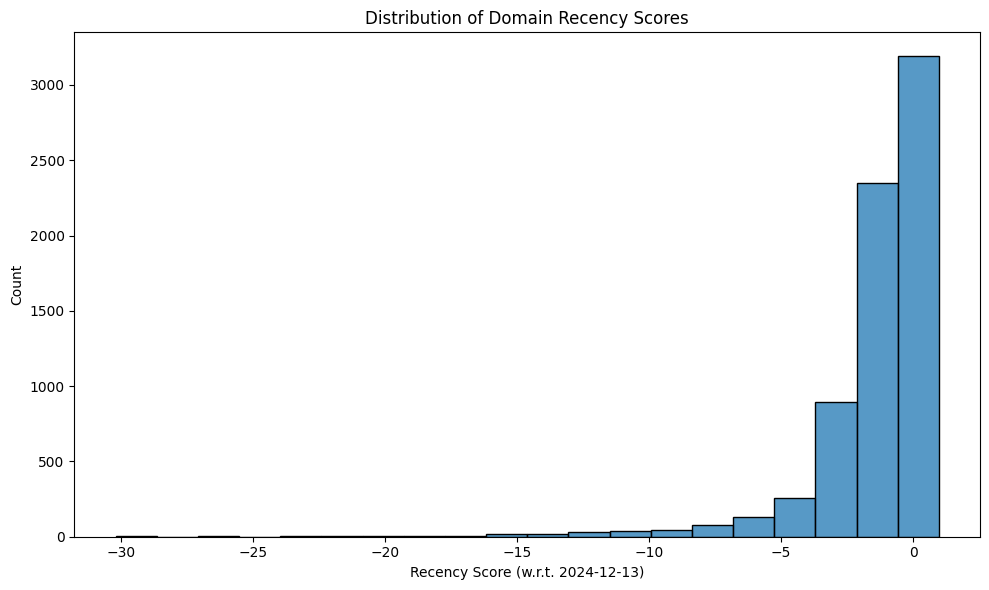

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot 1: Top domains by article count
plt.figure(figsize=(12, 6))
sns.barplot(data=domain_counts.head(30), x='articles_count', y='domain')
plt.title('Top 25 Domains by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Domain')
plt.tight_layout()
plt.show()

# Convert metrics to DataFrame and sort
metrics_df = pd.DataFrame.from_dict(domain_metrics, orient='index')
metrics_df = metrics_df.reset_index().rename(columns={'index': 'domain'})

# Create a separate sorted DataFrame for recency
recency_df = metrics_df.sort_values('recency_score_avg', ascending=False)

# Plot 2: Date range analysis (using original metrics_df for all data points)
plt.figure(figsize=(16, 6))
plt.scatter(recency_df['earliest'], recency_df['latest'], 
           s=recency_df['article_count']*20,
           alpha=0.5)
plt.title('Article Date Ranges by Domain')
plt.xlabel('Earliest Article Date')
plt.ylabel('Latest Article Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Recency score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=recency_df, x='recency_score_avg', bins=20)
plt.title('Distribution of Domain Recency Scores')
plt.xlabel(f'Recency Score (w.r.t. {reference_date.strftime("%Y-%m-%d")})')
plt.tight_layout()
plt.show()

In [40]:
# Convert metrics to DataFrame and sort
metrics_df = pd.DataFrame.from_dict(domain_metrics, orient='index')
metrics_df = metrics_df.reset_index().rename(columns={'index': 'domain'})

# Find domains with articles before 2005
cutoff_date = pd.Timestamp('2005-01-01')
old_articles = metrics_df[metrics_df['earliest'] < cutoff_date]

if len(old_articles) > 0:
    print(f"\nDomains with articles before 2005:")
    for _, row in old_articles.iterrows():
        print(f"Domain: {row['domain']}")
        print(f"Earliest article: {row['earliest'].strftime('%Y-%m-%d')}")
        print(f"Number of articles: {row['article_count']}")
        print("---")
else:
    print("\nNo articles found before 2005")

# Continue with your existing plotting code...


Domains with articles before 2005:
Domain: www.nytimes.com
Earliest article: 1984-10-30
Number of articles: 132
---
Domain: www.cato.org
Earliest article: 1995-05-11
Number of articles: 12
---
Domain: www.esd.ornl.gov
Earliest article: 1997-12-02
Number of articles: 1
---
Domain: www.washingtonpost.com
Earliest article: 1985-05-12
Number of articles: 80
---
Domain: www.snopes.com
Earliest article: 2004-04-05
Number of articles: 45
---
Domain: www.c-span.org
Earliest article: 2004-10-11
Number of articles: 17
---
Domain: yaledailynews.com
Earliest article: 2003-11-21
Number of articles: 3
---
Domain: aflcio.org
Earliest article: 2003-08-06
Number of articles: 5
---
Domain: www.coca-colacompany.com
Earliest article: 1985-04-23
Number of articles: 2
---


In [ ]:
# TODO

# Categorize claims by impact factor HIGH, MEDIUM, LOW

# Look for photo, video claims etc. 

# Rate the quality of the retrieved results
# Search Results Quality Metric
# 1. Relevance to the claim = Semantic Similarity + Keyword Matching
# 2. Trustworthiness - Source Credibility


# 3. ** Diversity - Multiple sources - 10 points
# 4. ** Viewpoint Diversity - Multiple viewpoints (Stance Detection) - 10 points
# 5. ** Date Recency - Recent sources - 10 points
# ** - things to think about later

# Run basic experiments
# Build wordcloud, topic extraction, sentiment analysis, class distribution of claims - Diversity
# NN, SVM, LR, KNN, RF, GB, XGB, CatBoost - Claim classification using text only
# NN, SVM, LR, KNN, RF, GB, XGB, CatBoost - Claim classification using text + source credibility + metadata

# Summarize each article, main topics, stance on the claim

In [ ]:
# apply semantic similarity based filtering on retrieved results
# apply keyword based filtering on retrieved results
# Combine the results from the two filters

# If no relevant evidence is found, this could imply as a claim is false

# Consider mulitple (speakers, subjects) in prompt templates
# Exclude date in result fetching - for now

In [2]:
from source_cred.source_credibility import SourceCredibility
from gather_webpages import should_filter_link
credibility_checker = SourceCredibility()

In [6]:
# Pick a random claim and all of its evidence urls
random_claim = random.choice(list(search_results.keys()))
evidence_urls = []
for query, page_results in search_results[random_claim].items():
    for page_num, results in page_results.items():
        evidence_urls.extend([result_object["link"] for result_object in results if not should_filter_link(result_object["link"])])
evidence_urls = list(set(evidence_urls))
print(random_claim)
print(len(evidence_urls))

"Climate activists vow to slaughter millions of dogs to ‘reduce carbon pawprint.’”
26


In [7]:
results = []
for url in tqdm(evidence_urls):
    print(url)
    domain = credibility_checker.extract_domain(url)
    ssl_status = credibility_checker.get_ssl_status(domain)
    domain_age = credibility_checker.get_domain_age(domain)
    wikipedia_presence = credibility_checker.check_social_media_presence(url)
    page_rank = credibility_checker.get_open_page_rank(domain)
    tld = credibility_checker.get_tld_score(domain)
    match, bias_rating, factual_rating, credibility_rating = credibility_checker.get_media_bias(domain)

    results.append({
        'url': url,
        'ssl_status': ssl_status,
        'domain_age': domain_age,
        'wikipedia_presence': wikipedia_presence,
        'page_rank': page_rank,
        "tld_score": tld,
        'matching_domain': match,
        'bias_rating': bias_rating,
        'factual_rating': factual_rating,
        'credibility_rating': credibility_rating
    })
    
# Save as a csv file
df_results = pd.DataFrame(results)

# Apply the maps to the dataframe
df_results['credibility_rating_score'] = df_results['credibility_rating'].map(credibility_checker.credibility_scores_map)
df_results['factual_rating_score'] = df_results['factual_rating'].map(credibility_checker.factual_ratings_map)
df_results['bias_rating_score'] = df_results['bias_rating'].map(credibility_checker.bias_scores_map)

df_results

  0%|          | 0/26 [00:00<?, ?it/s]

https://www.reuters.com/article/fact-check/wef-did-not-issue-guidance-to-slaughter-millions-of-pets-to-curb-climate-change-idUSL1N3361L6/


  4%|▍         | 1/26 [00:02<00:56,  2.28s/it]

https://www.aap.com.au/factcheck/dog-slaughter-claim-is-barking-mad/


  8%|▊         | 2/26 [00:06<01:16,  3.18s/it]

https://www.hsi.org/issues/dog-meat-trade/


 12%|█▏        | 3/26 [00:07<00:56,  2.46s/it]

https://www.forbes.com/sites/prakashdolsak/2023/04/09/dogs-are-humans-best-friends-could-we-reduce-their-carbon-footprint/


 15%|█▌        | 4/26 [00:09<00:48,  2.23s/it]

https://www.theguardian.com/world/article/2024/jul/30/turkey-approves-massacre-law-remove-millions-street-dogs


 19%|█▉        | 5/26 [00:11<00:44,  2.12s/it]

https://pa.media/blogs/fact-check/fact-check-the-wef-has-not-issued-a-plan-to-kill-pets-in-aid-of-climate-change-2/


 23%|██▎       | 6/26 [00:25<01:59,  6.00s/it]

https://www.reddit.com/r/askscience/comments/r51pn/does_a_dog_have_a_larger_carbon_footprint_than_an/


 27%|██▋       | 7/26 [00:27<01:33,  4.91s/it]

https://news.vt.edu/articles/2023/09/dogs_climate_change_expert.html


 31%|███       | 8/26 [00:29<01:11,  4.00s/it]

https://thekindpet.com/blogs/blog/what-is-the-environmental-impact-of-pets?srsltid=AfmBOopI_UcWaMANK40VPhzlrRxD7kkwYIxFd-u_oMhZoDP3KVeus5yg


 35%|███▍      | 9/26 [00:31<00:54,  3.23s/it]

https://www.independent.co.uk/climate-change/opinion/pets-uk-ownership-cats-dogs-carbon-environmental-impact-b1249610.html


 38%|███▊      | 10/26 [00:33<00:46,  2.90s/it]

https://earth.org/environmental-impact-of-pets/


 42%|████▏     | 11/26 [00:35<00:40,  2.73s/it]

https://www.euronews.com/my-europe/2024/02/27/fact-check-do-pets-pollute-as-much-as-cars


 46%|████▌     | 12/26 [00:38<00:37,  2.68s/it]

https://impact.ed.ac.uk/research/climate-environmental-crisis/truth-about-cats-and-dogs-and-climate/


 50%|█████     | 13/26 [00:40<00:33,  2.58s/it]

https://www.preventionweb.net/news/how-climate-change-will-affect-your-pet-and-how-help-them-cope


 54%|█████▍    | 14/26 [00:43<00:30,  2.57s/it]

https://www.zerosmart.co.uk/post/the-average-carbon-footprint-of-a-pet


 58%|█████▊    | 15/26 [00:45<00:25,  2.35s/it]

https://apnews.com/article/fact-check-dog-killing-climate-change-904289194639


 62%|██████▏   | 16/26 [00:47<00:24,  2.42s/it]

https://www.cravepetfoods.com/blogs/dog/climate-change-and-your-dog-what-you-need-to-know


 65%|██████▌   | 17/26 [00:49<00:19,  2.21s/it]

https://www.usatoday.com/story/news/factcheck/2022/12/09/fact-check-false-claim-activists-want-kill-dogs-lower-emissions/10807102002/


 69%|██████▉   | 18/26 [00:51<00:16,  2.05s/it]

https://www.reuters.com/world/asia-pacific/south-korea-offers-incentives-adoptions-ahead-ban-farming-dogs-food-2024-09-26/


 73%|███████▎  | 19/26 [00:53<00:15,  2.16s/it]

https://www.reddit.com/r/Dogfree/comments/10f51d6/until_we_stop_breeding_domestic_dogs_and_allowing/


 77%|███████▋  | 20/26 [00:55<00:12,  2.04s/it]

https://www.reuters.com/world/asia-pacific/south-koreas-parliament-expected-pass-bill-ban-dog-meat-trade-2024-01-09/


 81%|████████  | 21/26 [00:57<00:10,  2.01s/it]

https://climatefactchecks.org/wef-has-not-advised-the-slaughter-of-pets-to-fight-climate-change/


 85%|████████▍ | 22/26 [00:59<00:08,  2.16s/it]

https://www.cnn.com/2022/09/15/us/pets-climate-impact-lbg-wellness/index.html


 88%|████████▊ | 23/26 [01:01<00:06,  2.17s/it]

https://apnews.com/article/turkish-committee-approves-bill-to-regulate-stray-dogs-f4f865a743493ebe6368fe998e13e46d


 92%|█████████▏| 24/26 [01:03<00:04,  2.07s/it]

https://www.theguardian.com/australia-news/2023/oct/21/throw-a-dog-a-bean-how-to-reduce-the-carbon-footprint-of-your-pets


 96%|█████████▌| 25/26 [01:06<00:02,  2.20s/it]

https://www.rumorguard.org/post/no-one-is-recommending-killing-pets-to-fight-climate-change


100%|██████████| 26/26 [01:13<00:00,  2.83s/it]


,url,ssl_status,domain_age,wikipedia_presence,page_rank,tld_score,matching_domain,bias_rating,factual_rating,credibility_rating,credibility_rating_score,factual_rating_score,bias_rating_score
0,https://www.reuters.com/article/fact-check/wef...,True,31.517808,"{'wikipedia_presence': True, 'wikipedia_page_u...",7,7.0,Reuters (www.reuters.com),center,VERY HIGH,HIGH CREDIBILITY,4.0,NaN,3.0
1,https://www.aap.com.au/factcheck/dog-slaughter...,True,0.000000,"{'wikipedia_presence': True, 'wikipedia_page_u...",5,6.8,Australian Associated Press (AAP) (aap.com.au),center,HIGH,HIGH CREDIBILITY,4.0,5.0,3.0
2,https://www.hsi.org/issues/dog-meat-trade/,True,24.750685,"{'wikipedia_presence': True, 'wikipedia_page_u...",5,8.0,None,None,None,None,NaN,NaN,NaN
3,https://www.forbes.com/sites/prakashdolsak/202...,True,31.479452,"{'wikipedia_presence': True, 'wikipedia_page_u...",8,7.0,Forbes (www.forbes.com),center,MOSTLY FACTUAL,HIGH CREDIBILITY,4.0,4.0,3.0
4,https://www.theguardian.com/world/article/2024...,True,30.427397,"{'wikipedia_presence': True, 'wikipedia_page_u...",8,7.0,The Guardian (www.theguardian.com),leftcenter,MIXED,MEDIUM CREDIBILITY,2.0,3.0,2.0
5,https://pa.media/blogs/fact-check/fact-check-t...,True,6.326027,"{'wikipedia_presence': True, 'wikipedia_page_u...",5,NaN,PA Media (pa.media),center,VERY HIGH,HIGH CREDIBILITY,4.0,NaN,3.0
6,https://www.reddit.com/r/askscience/comments/r...,True,19.602740,"{'wikipedia_presence': True, 'wikipedia_page_u...",8,7.0,None,None,None,None,NaN,NaN,NaN
7,https://news.vt.edu/articles/2023/09/dogs_clim...,True,37.063014,"{'wikipedia_presence': True, 'wikipedia_page_u...",5,9.5,None,None,None,None,NaN,NaN,NaN
8,https://thekindpet.com/blogs/blog/what-is-the-...,True,3.073973,"{'wikipedia_presence': False, 'wikipedia_page_...",3,7.0,None,None,None,None,NaN,NaN,NaN
9,https://www.independent.co.uk/climate-change/o...,True,28.353425,"{'wikipedia_presence': True, 'wikipedia_page_u...",7,6.8,Bishop’s Stortford Independent (bishopsstortfo...,center,HIGH,HIGH CREDIBILITY,4.0,5.0,3.0


In [8]:
# Save as a csv file
df_results = pd.DataFrame(results)

# Apply the maps to the dataframe
df_results['credibility_rating_score'] = df_results['credibility_rating'].map(credibility_checker.credibility_scores_map)
df_results['factual_rating_score'] = df_results['factual_rating'].map(credibility_checker.factual_ratings_map)
df_results['bias_rating_score'] = df_results['bias_rating'].map(credibility_checker.bias_scores_map)

df_results

,url,ssl_status,domain_age,wikipedia_presence,page_rank,tld_score,matching_domain,bias_rating,factual_rating,credibility_rating,credibility_rating_score,factual_rating_score,bias_rating_score
0,https://www.reuters.com/article/fact-check/wef...,True,31.517808,"{'wikipedia_presence': True, 'wikipedia_page_u...",7,7.0,Reuters (www.reuters.com),center,VERY HIGH,HIGH CREDIBILITY,4.0,NaN,3.0
1,https://www.aap.com.au/factcheck/dog-slaughter...,True,0.000000,"{'wikipedia_presence': True, 'wikipedia_page_u...",5,6.8,Australian Associated Press (AAP) (aap.com.au),center,HIGH,HIGH CREDIBILITY,4.0,5.0,3.0
2,https://www.hsi.org/issues/dog-meat-trade/,True,24.750685,"{'wikipedia_presence': True, 'wikipedia_page_u...",5,8.0,None,None,None,None,NaN,NaN,NaN
3,https://www.forbes.com/sites/prakashdolsak/202...,True,31.479452,"{'wikipedia_presence': True, 'wikipedia_page_u...",8,7.0,Forbes (www.forbes.com),center,MOSTLY FACTUAL,HIGH CREDIBILITY,4.0,4.0,3.0
4,https://www.theguardian.com/world/article/2024...,True,30.427397,"{'wikipedia_presence': True, 'wikipedia_page_u...",8,7.0,The Guardian (www.theguardian.com),leftcenter,MIXED,MEDIUM CREDIBILITY,2.0,3.0,2.0
5,https://pa.media/blogs/fact-check/fact-check-t...,True,6.326027,"{'wikipedia_presence': True, 'wikipedia_page_u...",5,NaN,PA Media (pa.media),center,VERY HIGH,HIGH CREDIBILITY,4.0,NaN,3.0
6,https://www.reddit.com/r/askscience/comments/r...,True,19.602740,"{'wikipedia_presence': True, 'wikipedia_page_u...",8,7.0,None,None,None,None,NaN,NaN,NaN
7,https://news.vt.edu/articles/2023/09/dogs_clim...,True,37.063014,"{'wikipedia_presence': True, 'wikipedia_page_u...",5,9.5,None,None,None,None,NaN,NaN,NaN
8,https://thekindpet.com/blogs/blog/what-is-the-...,True,3.073973,"{'wikipedia_presence': False, 'wikipedia_page_...",3,7.0,None,None,None,None,NaN,NaN,NaN
9,https://www.independent.co.uk/climate-change/o...,True,28.353425,"{'wikipedia_presence': True, 'wikipedia_page_u...",7,6.8,Bishop’s Stortford Independent (bishopsstortfo...,center,HIGH,HIGH CREDIBILITY,4.0,5.0,3.0


In [ ]:
# Get average page rank
# Get average domain age
# Get average domain age

print("Average domain age: ", df_results['domain_age'].mean())
print("Average tld score: ", df_results['tld_score'].mean())
print("Average page rank: ", df_results['page_rank'].mean())
print("Average bias rating: ", df_results['bias_rating_score'].mean(), "/ 5")
print("Average factual rating: ", df_results['factual_rating_score'].mean(), "/ 6")
print("Average credibility rating: ", df_results['credibility_rating_score'].mean(), "/ 4")